<a href="https://colab.research.google.com/github/L4ncelot1024/Learn_Deep_Learning_Le_Wagon/blob/main/Day3/02_Predicting_Engine_failure_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Engine Failure with RNN

In this practicals, the goal is to predict the failure of an engine. The training dataset is made of time series obtained from several sensors on the engine until failure. The test dataset is made of the start of these time series and a failure date.

We will build a simple RNN taking as input the multi-dimensional time serie characterizing the engine and learn its parameters to predict the time of failure at each instant. At the start, the best prediction without any input data should be the average of the failure times in the dataset and as more and more data is fed in the RNN, it should give a better and better estimate.

The dataset is provided by [NASA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import gamma
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## 1. Downloading the data

This need to be done only once!

You can find the data on the website of the [NASA](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

In [ ]:
# we create a folder in the temporary space to store the data
%mkdir data
%cd data

/content/data


In [ ]:
!wget 'https://www.di.ens.fr/~lelarge/CMAPSSData.zip'

--2021-01-26 23:28:54--  https://www.di.ens.fr/~lelarge/CMAPSSData.zip
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘CMAPSSData.zip’

CMAPSSData.zip          [             <=>    ]  11.85M  1.95MB/s    in 13s     

2021-01-26 23:29:07 (970 KB/s) - ‘CMAPSSData.zip’ saved [12425978]



In [ ]:
!unzip CMAPSSData.zip

Archive:  CMAPSSData.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt           
  inflating: RUL_FD004.txt           
  inflating: test_FD001.txt          
  inflating: test_FD002.txt          
  inflating: test_FD003.txt          
  inflating: test_FD004.txt          
  inflating: train_FD001.txt         
  inflating: train_FD002.txt         
  inflating: train_FD003.txt         
  inflating: train_FD004.txt         


In [ ]:
%cd ..

/content


In [ ]:
# checking the data folder have been downloaded
%ls

data/  sample_data/


In [ ]:
%ls data

 CMAPSSData.zip                     RUL_FD003.txt    test_FD004.txt
'Damage Propagation Modeling.pdf'   RUL_FD004.txt    train_FD001.txt
 readme.txt                         test_FD001.txt   train_FD002.txt
 RUL_FD001.txt                      test_FD002.txt   train_FD003.txt
 RUL_FD002.txt                      test_FD003.txt   train_FD004.txt


## 2. Reading the data

We need first to build the data table we'll work with. First, have a look on the `readme` of the dataset on the following cell to understand how to get your train and test dataset with both the input data and target to predict at each time step. This step is very important to understand the data you'll manipulate

In [ ]:
%pycat ./data/readme.txt

In [ ]:
def get_CMAPSSData(nb_file):
    # This function loads the train and test datasets and format them with column names
    # It takes as input the nb_file since you have multiple engine information
    # 
    dataset_train = pd.read_csv('./data/train_FD00{}.txt'.format(nb_file),
                                sep=' ', header=None).drop([26, 27], axis=1)
    dataset_test = pd.read_csv('./data/test_FD00{}.txt'.format(nb_file),
                               sep=' ', header=None).drop([26, 27], axis=1)
    col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
                 's9',
                 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
    dataset_train.columns = col_names
    dataset_test.columns = col_names
    # It also loads the vrector of true Remaining Useful Life (RUL) values for 
    # the test data
    test_truth = pd.read_csv('./data/RUL_FD00{}.txt'.format(nb_file),
                             sep=' ', header=None).drop([1], axis=1)
    test_truth.columns = ['more']
    test_truth['id'] = test_truth.index + 1

    return dataset_train, dataset_test, test_truth


In [ ]:
dataset_train, dataset_test, test_truth = get_CMAPSSData(1)

print(dataset_train.shape)
print(dataset_test.shape)
print(test_truth.shape)

(20631, 26)
(13096, 26)
(100, 2)


Our goal is to predict the **time-to-failure**, which stands for the number of cycle left before the next failure. This quantity is helpful to anticipate a failure and whan it will occur.

We need to add this target in both datasets.

- In the train set, we can simply infer  this for each row by looking for each trajectory (so each `id`) the max of the cycle reported and substract to it the current cycle since the cycle ends when it fails.
- In the test set, we don't have the data points until the failure, since we want to predict in how many cycles it will occur. So to restore the label, we need to use the information provided in the column `more` of the dataset `test_truth`. Following the same logic we use for the train, we can first retrieve the failure cycle (just by summing for each id the max cycle with its `more` value, this will give the time of the failure (`run-to-failure`) and then substract to it a cycle to get the current `time-to-failure`

In [ ]:
# Train set
# Build the target column on the training dataset
dataset_train['ttf'] = ...

# Test set
# Preparing the target column rtf = run to failure in test
test_truth['rtf'] = ...

# Build the ttf column using the rtf column and droping it
dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)



<details>
  <summary>View solution</summary>
    
```python
# Build the target column on the training dataset
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max) - dataset_train['cycle']

# Preparing the target column rtf = run to failure
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

test_truth['rtf'] = test_truth['more'] + rul['max']
test_truth_clean = test_truth.drop('more', axis=1)

dataset_test = dataset_test.merge(test_truth_clean, on=['id'], how='left')
dataset_test['ttf'] = dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)

```
</details>



## Preparing the features

First, have a look at your feature to check their range and variance. We suggest to plot for each feature column its distribution as an histogram.

In [ ]:
feature_columns = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8','s9','s10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

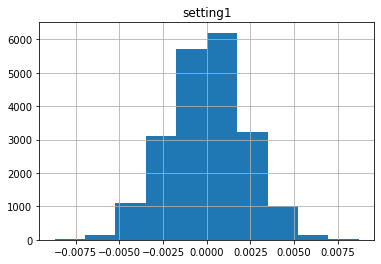

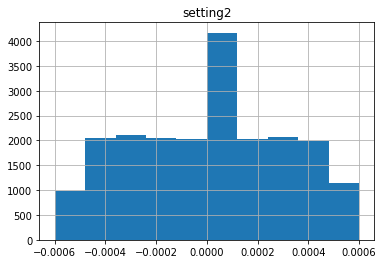

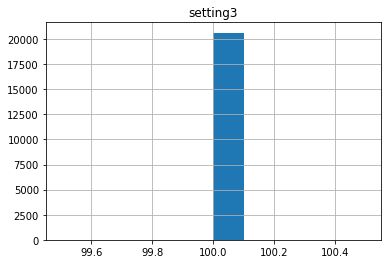

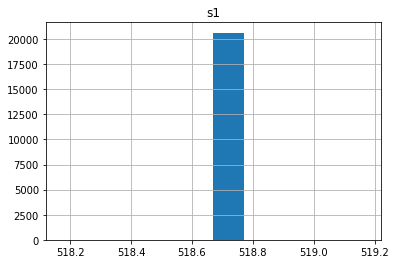

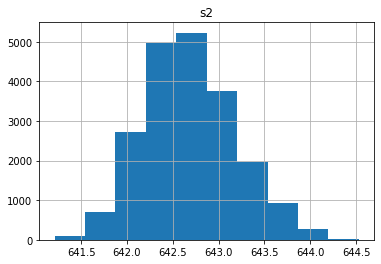

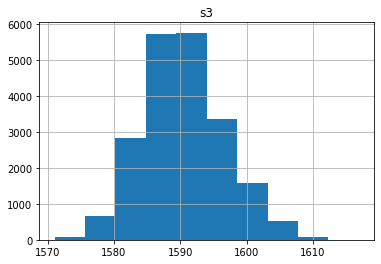

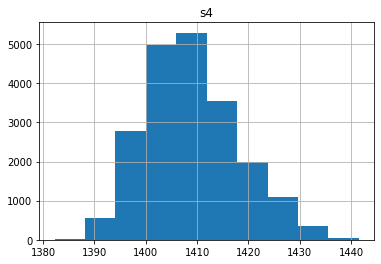

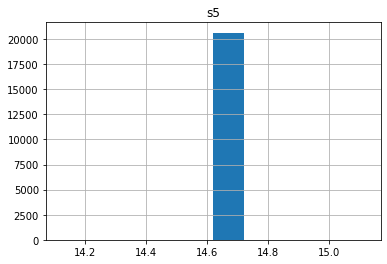

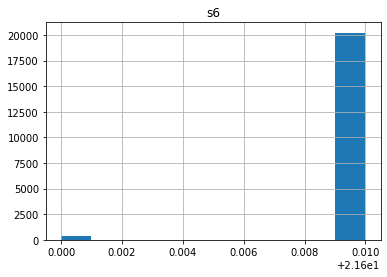

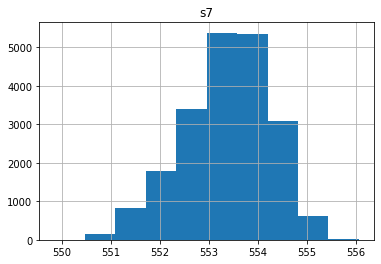

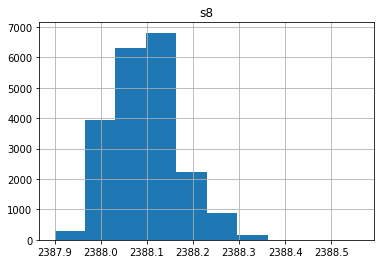

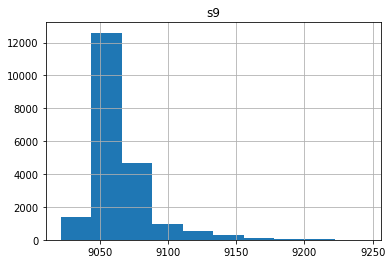

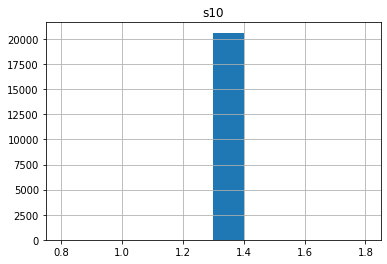

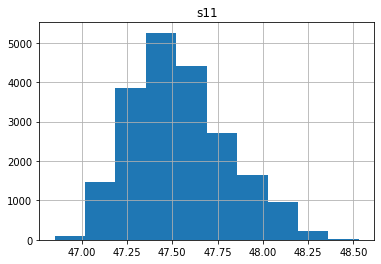

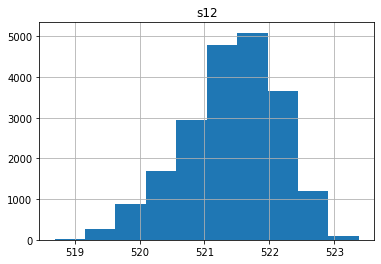

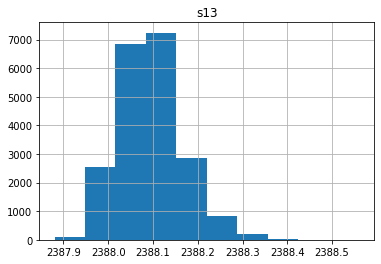

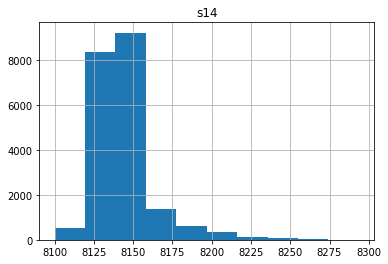

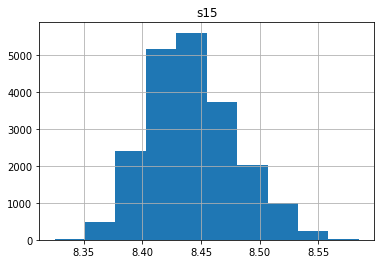

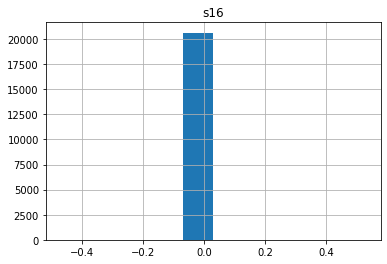

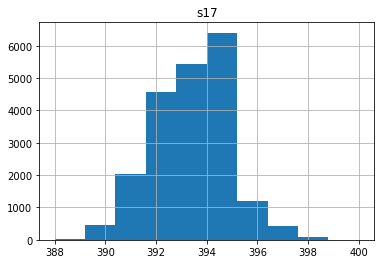

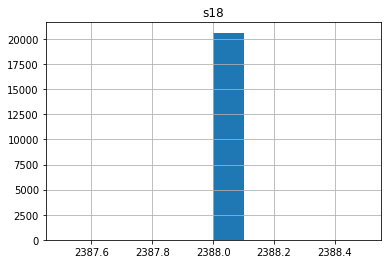

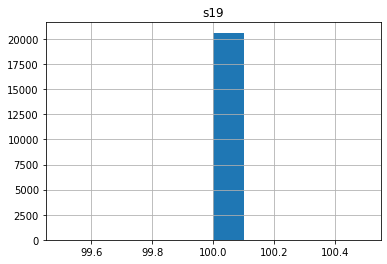

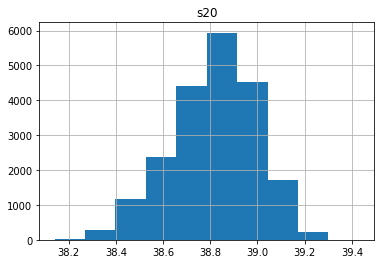

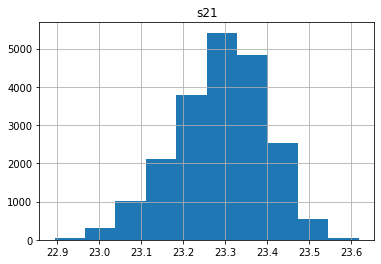

In [ ]:
for feature_column in feature_columns:
  dataset_train[feature_column].hist()
  plt.title(feature_column)
  plt.show()

What do you observe? Is there any feature which is constant? Are the ranges comparable?

Here we apply some transformations to help our model to digest input feature:
- Removing constant feature;
- Scaling feature: here we suggest to use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn

In [ ]:
# Removing constant feature
# YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
relevant_features_col_name = []
for col in feature_columns:
    if not (len(dataset_train[col].unique()) == 1):
        relevant_features_col_name.append(col)

print(f'{len(feature_columns) - len(relevant_features_col_name)} features removed because constant')
df_train = dataset_train[['id', 'cycle'] + relevant_features_col_name + ['ttf']]
df_test = dataset_test[['id', 'cycle'] + relevant_features_col_name + ['ttf']]
```
</details>



In [ ]:
# Scaling feature: here we suggest to use the MinMaxScaler from sklearn
# YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
sc = MinMaxScaler()
df_train[relevant_features_col_name] = sc.fit_transform(df_train[relevant_features_col_name])
df_test[relevant_features_col_name] = sc.transform(df_test[relevant_features_col_name])
```
</details>



As a sanity check, have another look at the distribution of the features you selected:

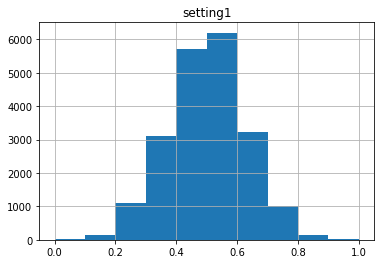

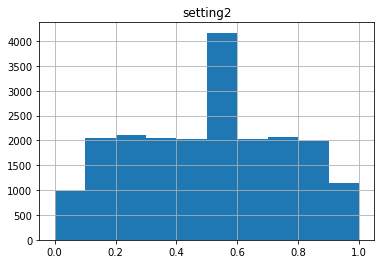

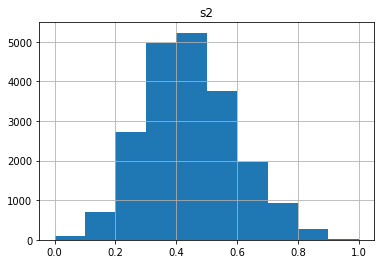

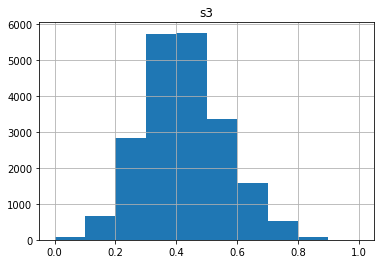

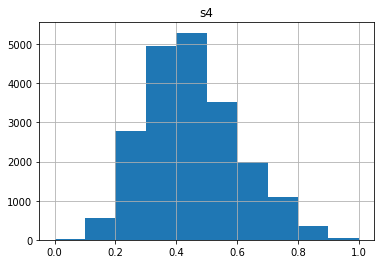

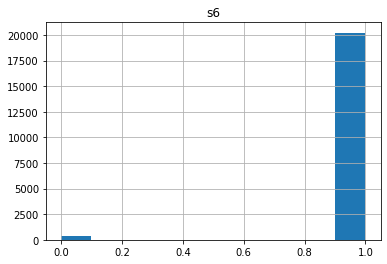

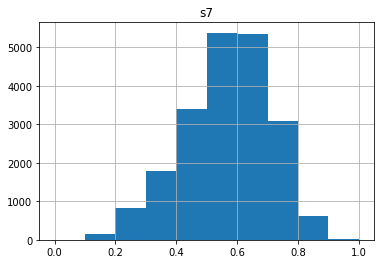

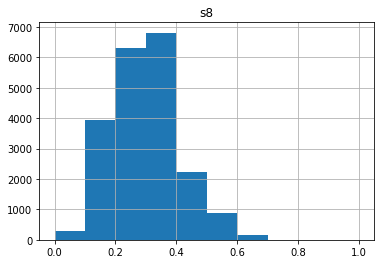

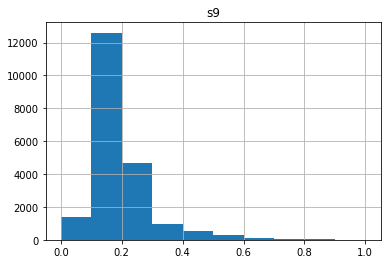

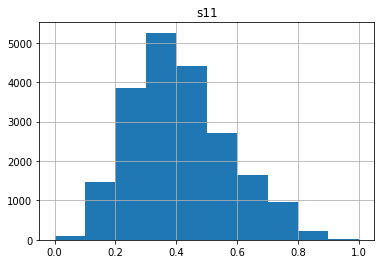

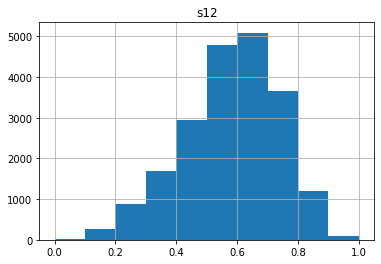

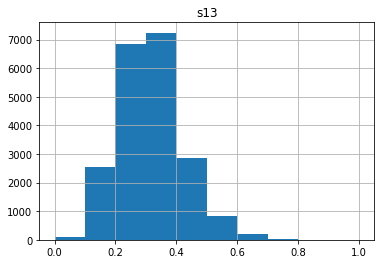

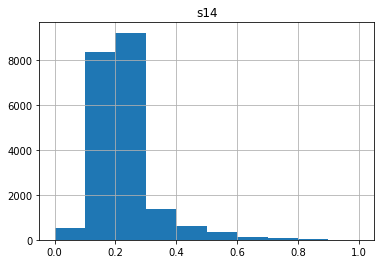

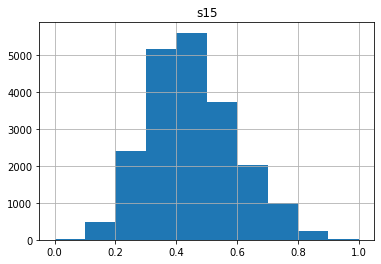

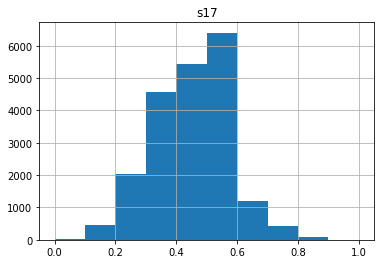

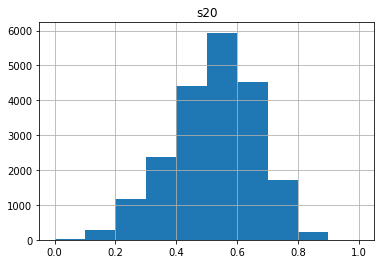

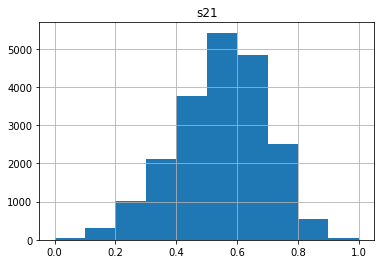

In [ ]:
for feature_column in relevant_features_col_name:
  df_train[feature_column].hist()
  plt.title(feature_column)
  plt.show()

## LSTM Classifier

### Overview

### Preparing input

The task is to to build a model able to predict for an input multi-dimensional time series if a failure occurs at each time-step. We chose to work with a classification model to predict if a failure will come within 30 days (= cycles). 

We will build an LSTM on fixed-size sequence extracted from each input time serie. This process can be illustrated as applying a sliding window  of *seq_length* (in practive 50 is enough, it needs to be at least >= 30) on the input time-series. This will help to model short-term non-linearities.

To prepare the data, you need to:
- add a binary target column to the input dataset (accounting for the event of a failure at a given timestep in the incoming 30 timesteps);
- prepare train and test sequences;

In [ ]:
# Add to df_train and df_test a binary column 'label' for the target
# YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
# Add to df_train and df_test a column 'label' for the target
period = 30
label_column = 'label'
df_train[label_column] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test[label_column] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
```
</details>



In [ ]:
df_train.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0


In [ ]:
# Create a function to generate the input sequences of size (seq_length, nb_features).
# This function will be apply on each time serie and then you'll concatenate its
# outputs on all the timeseries to get your X and y.
# 
# NB: you need to add a zeros-padding to the input feature and target to be able
#   to predict already the failure with only the first timestamp, i.e. in this case
#   you want to predict using the input [0, 0, ..., 0, timestamp_0].

def gen_X_sequence(id_df, seq_length, feature_columns):
  # Function taking a dataframe for only one time series (ie for only one id)
  # and returning the feature input sequences.
  # YOUR CODE HERE
  pass

def gen_y_sequence(id_df, seq_length, y_column):
  # Function taking a dataframe for only one time series (ie for only one id)
  # and returning the target vector.
  # YOUR CODE HERE
  pass


<details>
  <summary>View solution</summary>
    
```python
def gen_X_sequence(id_df, seq_length, feature_columns):
  X_array = []
  # adding a 0 padding 
  feature_array = np.concatenate((np.zeros((seq_length - 1, len(feature_columns))), id_df[feature_columns].values), axis=0)
  for start in range(len(feature_array) - seq_length):
    X_array.append(feature_array[start: start + seq_length])
  return np.array(X_array)

def gen_y_sequence(id_df, seq_length, y_column):
  y_array = np.concatenate((np.zeros(seq_length - 1), id_df[y_column].values), axis=0)
  return np.array([y_array[stop] for stop in range(seq_length, len(y_array))])
```
</details>



In [ ]:
# Applying your code on the train and test data
seq_length = 50

input_ids = df_train['id'].unique()
X_train = np.concatenate([gen_X_sequence(df_train[df_train['id']==id], seq_length, relevant_features_col_name) for id in input_ids])
y_train = np.concatenate([gen_y_sequence(df_train[df_train['id']==id], seq_length, label_column) for id in input_ids])
print(X_train.shape)
print(y_train.shape)

input_ids = df_test['id'].unique()
X_test = np.concatenate([gen_X_sequence(df_test[df_test['id']==id], seq_length, relevant_features_col_name) for id in input_ids])
y_test = np.concatenate([gen_y_sequence(df_test[df_test['id']==id], seq_length, label_column) for id in input_ids])
print(X_test.shape)
print(y_test.shape)

(20531, 50, 17)
(20531,)
(12996, 50, 17)
(12996,)


### Architecture

Let's build a 2-layers LSTM classifier.

Preliminary questions: 
- What are the layers your network will contain?
- Which layer need to return a sequence and which one need to return a single element?
- Which loss do you need? Which metrics do you want to optimize for?

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

def build_LSTM_classifier(seq_length, nb_features, n_unit_1=100, n_unit_2=50, dropout=0.2):
  # This function should build your model and compile it with relevant loss, optimizer and metrics.
  # It then returns your model


<details>
  <summary>View solution</summary>
    
```python
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

def build_LSTM_classifier(seq_length, nb_features, n_unit_1=100, n_unit_2=50, dropout=0.2):
  model = Sequential()

  model.add(LSTM(
          input_shape=(seq_length, nb_features),
          units=n_unit_1,
          return_sequences=True))
  model.add(Dropout(dropout))

  model.add(LSTM(
            units=n_unit_2,
            return_sequences=False))
  model.add(Dropout(dropout))

  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = build_LSTM_classifier(seq_length, len(relevant_features_col_name))
model.summary()
```
</details>



### Training

Now it's time to train your network ! You can simply do that with a 1-line call to the `.fit()` of your model. Try first with simple parameters as a sanity check to make sure the model converges (i.e. the loss decreases and your metrics evolve in the right direction along training)

In [ ]:
# YOUR CODE HERE



<details>
  <summary>View solution</summary>
    
```python
model.fit(X_train, y_train, epochs=10, batch_size=200)
```
</details>



### Evaluation

Apply your model on the test data and compare it with the reality. Try here to print/plot metrics you should care about, and also some statistics to understand where you're model is failing (e.g. *is it pessimistic and predicting way too often a failure?*)

In [ ]:
# YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
from sklearn.metrics import confusion_matrix

# Compute metrics on test
metrics_test = model.evaluate(X_test, y_test, verbose=1, batch_size=200)
print('Accurracy: {}'.format(metrics_test[1]))

# Display confusion matrix
y_pred = model.predict_classes(X_test)
print('Confusion Matrix: \n',confusion_matrix(y_test ,y_pred))
```
</details>



### Improving Training

Now that you can evaluate your model on the training set, you can try to improve it while changing the architecture, adding an early stopping using a validation set during training (see the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping))

In [ ]:
# Your code here


<details>
  <summary>View solution</summary>
    
```python
model = build_LSTM_classifier(seq_length, len(relevant_features_col_name))

model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])
```
</details>



## Predicting Machine Failure

Let's conclude by providing a way to predict for any machine in the test set its probability of having a failure in the incoming 30 days.

In [ ]:
def prob_failure(machine_id, df, model, seq_length):
  # Should return the probability computed by your trained model that the 
  # machine_id with its timeserie in the df will have a failure in the incoming
  # 30 days
  # YOUR CODE HERE


<details>
  <summary>View solution</summary>
    
```python
def prob_failure(machine_id, df, model, seq_length):
    machine_df = df[df.id == machine_id]
    machine_test = gen_sequence(machine_df, seq_length, relevant_features_col_name)
    m_pred = model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob
```
</details>

